# Import Packages

In [47]:
import html
import re
import time
import warnings
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import umap
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment

from transformers import (
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix,
)
from sklearn.base import BaseEstimator

from skopt import BayesSearchCV
from skopt.callbacks import DeltaYStopper
from skopt.space import Categorical
from skopt.utils import point_asdict

warnings.filterwarnings("ignore")
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"
import json  
import joblib 


# Load Data

In [48]:
df_min_cleaned = pd.read_csv("min_cleaned_tweets.csv")
texts = df_min_cleaned["clean_text"].astype(str).tolist()

df_min_cleaned_sample = pd.read_csv("min_cleaned_sample_tweets.csv")

# Embedding

In [49]:
# ---------------------------
# CONFIG
# ---------------------------
EMB_DIM = 768
RANDOM_STATE = 42

# ==========================================================
# Load BERTweet embeddings (no normalization)
# ==========================================================
model_name = "finiteautomata/bertweet-base-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)
device = torch.device("mps" if torch.backends.mps.is_available() 
                      else "cuda" if torch.cuda.is_available() 
                      else "cpu")
model.to(device)
model.eval()
print(f" Model loaded on device: {device}")

def get_logits(texts, batch_size=32):
    all_logits = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting logits"):
        batch = texts[i:i+batch_size]
        tokens = tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            outputs = model(**tokens)
        all_logits.append(outputs.logits.detach().cpu().numpy())
    return np.vstack(all_logits)

def get_hidden_embeddings(texts, batch_size=32, layer=-2):
    all_embs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting embeddings"):
        batch = texts[i:i+batch_size]
        tokens = tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            outputs = model(**tokens, output_hidden_states=True)
            hidden_states = outputs.hidden_states[layer]
            all_embs.append(hidden_states.mean(dim=1).cpu().numpy())
    return np.vstack(all_embs)

# ---------------------------
# Metrics
# ---------------------------
def hungarian_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    r, c = linear_sum_assignment(-cm)
    return cm[r, c].sum() / cm.sum()

def evaluate_full(X, y_true_int, labels, sil_metric):
    sil = silhouette_score(X, labels, metric=sil_metric)
    ari = adjusted_rand_score(y_true_int, labels)
    nmi = normalized_mutual_info_score(y_true_int, labels)
    acc = hungarian_accuracy(y_true_int, labels)
    return sil, ari, nmi, acc

# ---------------------------
# Prepare Data
# ---------------------------
texts_sample = df_min_cleaned_sample["clean_text"].astype(str).tolist()
texts_full   = df_min_cleaned["clean_text"].astype(str).tolist()

# Encode sentiments consistently
le = LabelEncoder()
le.fit(df_min_cleaned["airline_sentiment"].astype(str))
df_min_cleaned["label_encoded"] = le.transform(df_min_cleaned["airline_sentiment"].astype(str))
df_min_cleaned_sample["label_encoded"] = le.transform(df_min_cleaned_sample["airline_sentiment"].astype(str))

texts_full = df_min_cleaned["clean_text"].tolist()
texts_sample = df_min_cleaned_sample["clean_text"].tolist()
y_full = df_min_cleaned["label_encoded"].values
y_sample = df_min_cleaned_sample["label_encoded"].values

#X_emb_sample = get_hidden_embeddings(texts_sample)
#X_logits_sample = get_logits(texts_sample)
#X_hybrid_sample = np.concatenate([X_emb_sample, X_logits_sample], axis=1).astype(np.float64)

#X_emb_full = get_hidden_embeddings(texts_full)
#X_logits_full = get_logits(texts_full)
#X_hybrid_full = np.concatenate([X_emb_full, X_logits_full], axis=1).astype(np.float64)


 Model loaded on device: mps


In [50]:
SAMPLE_PATH = "model/X_bertweet_sample.npy"
FULL_PATH   = "model/X_bertweet_full.npy"

os.makedirs("model", exist_ok=True)

def compute_hybrid_embeddings(texts, batch_size=32):
    """Compute mean-pooled hidden embeddings + logits, and concatenate."""
    X_emb = get_hidden_embeddings(texts, batch_size=batch_size)
    X_logits = get_logits(texts, batch_size=batch_size)
    X_hybrid = np.concatenate([X_emb, X_logits], axis=1).astype(np.float64)
    return X_hybrid

In [58]:
# ---------------------------
# SAMPLE DATASET
# ---------------------------
if os.path.exists(SAMPLE_PATH):
    print("Loading cached sample embeddings...")
    X_hybrid_sample = np.load(SAMPLE_PATH, mmap_mode="r")
else:
    print("Computing sample embeddings (first run)...")
    X_hybrid_sample = compute_hybrid_embeddings(texts_sample)
    np.save(SAMPLE_PATH, X_hybrid_sample)
    print(f"Saved sample embeddings → {SAMPLE_PATH}")

# ---------------------------
# FULL DATASET
# ---------------------------
if os.path.exists(FULL_PATH):
    print("Loading cached full embeddings...")
    X_hybrid_full = np.load(FULL_PATH, mmap_mode="r")
else:
    print("Computing full embeddings (first run)...")
    X_hybrid_full = compute_hybrid_embeddings(texts_full)
    np.save(FULL_PATH, X_hybrid_full)
    print(f"Saved full embeddings → {FULL_PATH}")

Loading cached sample embeddings...
Loading cached full embeddings...


# Helper Functions

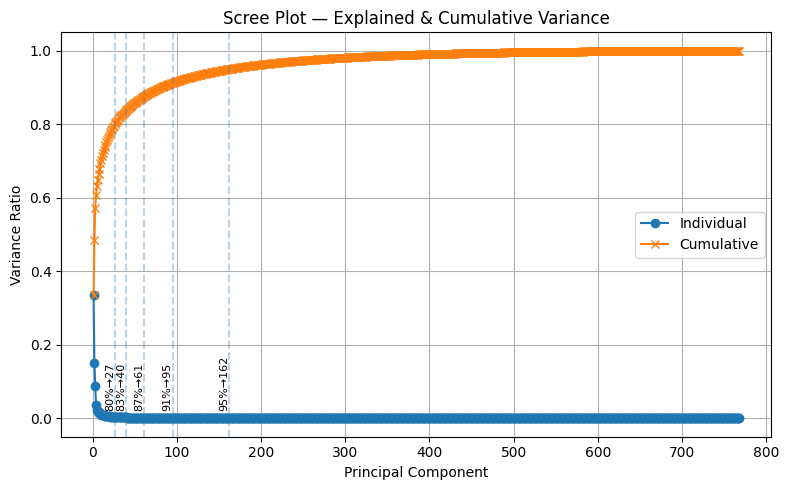

PCA n_components candidates (80–95% cum var): [27, 40, 61, 95, 162]


In [52]:
# ---------------------------
# PCA Scree Plot + pick 5 n_components (80–95% cum var, evenly spaced)
# ---------------------------
def pick_pca_candidates(X, pct_low=0.80, pct_high=0.95, k=5, max_components=None, plot=True):
    if max_components is None:
        max_components = min(EMB_DIM, X.shape[1])
    Xs   = StandardScaler().fit_transform(X)
    pca  = PCA(n_components=max_components, random_state=RANDOM_STATE)
    pca.fit(Xs)
    evr  = pca.explained_variance_ratio_
    cum  = np.cumsum(evr)

    thresholds = np.linspace(pct_low, pct_high, k)
    comps = []
    for t in thresholds:
        idx = int(np.argmax(cum >= t)) + 1
        comps.append(idx)

    # dedupe while preserving order
    seen = set(); comps_unique = []
    for c in comps:
        if c not in seen:
            comps_unique.append(c); seen.add(c)

    # ensure exactly k values (best-effort padding)
    while len(comps_unique) < k:
        step = max(1, (comps_unique[-1] - comps_unique[0]) // (k-1))
        candidate = min(max_components, comps_unique[-1] + step)
        if candidate not in seen:
            comps_unique.append(candidate); seen.add(candidate)
        else:
            candidate = min(max_components, candidate+1)
            if candidate not in seen:
                comps_unique.append(candidate); seen.add(candidate)
            else:
                break

    comps_unique = sorted(comps_unique)[:k]

    if plot:
        xs = np.arange(1, len(evr)+1)
        plt.figure(figsize=(8,5))
        plt.plot(xs, evr, marker='o', label='Individual')
        plt.plot(xs, cum, marker='x', label='Cumulative')
        for t, c in zip(thresholds, comps):
            plt.axvline(c, linestyle='--', alpha=0.3)
            plt.text(c, 0.02, f'{int(t*100)}%→{c}', rotation=90, va='bottom', ha='right', fontsize=8)
        plt.title('Scree Plot — Explained & Cumulative Variance')
        plt.xlabel('Principal Component'); plt.ylabel('Variance Ratio')
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return comps_unique, cum

pca_candidates, _cum = pick_pca_candidates(
    X_hybrid_sample, pct_low=0.80, pct_high=0.95, k=5, max_components=EMB_DIM, plot=True
)
print("PCA n_components candidates (80–95% cum var):", pca_candidates)

# Fixed UMAP candidate grids 
umap_neighbors  = [15, 30, 45, 60, 75, 100, 150, 200]
umap_min_dist   = [0.1, 0.2, 0.3, 0.4, 0.5]
umap_components = [16, 32, 48, 64, 96, 128]

# ---------------------------
# ClusteringPipeline class (for BayesSearchCV)
# ---------------------------
_LAST_TRIAL = deque(maxlen=1)

class ClusteringPipeline(BaseEstimator):
    def __init__(self,
                 reducer='pca', n_components=50,
                 n_neighbors=15, min_dist=0.1, n_components_umap=16,
                 model='kmeans', cov_type='full', linkage='average'):
        self.reducer = reducer
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components_umap = n_components_umap
        self.model = model
        self.cov_type = cov_type
        self.linkage = linkage

    def fit(self, X, y=None):
       _LAST_TRIAL.clear()
       _LAST_TRIAL.append({
           'reducer'          : self.reducer,
           'n_components'     : self.n_components,
           'n_neighbors'      : self.n_neighbors,
           'min_dist'         : self.min_dist,
           'n_components_umap': self.n_components_umap,
           'model'            : self.model,
           'cov_type'         : self.cov_type,
           'linkage'          : self.linkage,
       })


       # ---------------- Reducer ----------------
       if self.reducer == 'pca':
           self.reducer_ = PCA(n_components=self.n_components, random_state=RANDOM_STATE)
           X_std = StandardScaler().fit_transform(X)
           X_red = self.reducer_.fit_transform(X_std)
           self.metric = "cosine"   # same metric you used for Agglo/KMeans after PCA
       else:
           self.reducer_ = umap.UMAP(
               n_neighbors=self.n_neighbors,
               min_dist=self.min_dist,
               n_components=self.n_components_umap,
               metric='cosine',
               random_state=RANDOM_STATE,
               n_epochs=120,
               low_memory=True
           )
           X_l2 = normalize(X)
           X_red = self.reducer_.fit_transform(X_l2)
           self.metric = "cosine"


       # ---------------- Clustering ----------------
       if self.model == 'kmeans':
           self.clusterer_ = KMeans(
               n_clusters=3, n_init=10, algorithm='elkan', random_state=RANDOM_STATE
           )
           X_use = normalize(X_red)
           labels = self.clusterer_.fit_predict(X_use)


       elif self.model == 'gmm':
           self.clusterer_ = GaussianMixture(
               n_components=3, n_init=10, random_state=RANDOM_STATE,
               covariance_type=self.cov_type
           )
           X_use = np.asarray(X_red, dtype=np.float64)
           try:
               labels = self.clusterer_.fit_predict(X_use)
           except ValueError:
               # small safeguard for numerical issues
               self.clusterer_ = GaussianMixture(
                   n_components=3, n_init=10, random_state=RANDOM_STATE,
                   covariance_type=self.cov_type, reg_covar=1e-5
               )
               labels = self.clusterer_.fit_predict(X_use)
           self.metric = "euclidean"


       else:  # Agglomerative
           self.clusterer_ = AgglomerativeClustering(
               n_clusters=3, linkage=self.linkage, metric='cosine'
           )
           X_use = normalize(X_red)
           labels = self.clusterer_.fit_predict(X_use)
           self.metric = "cosine"


       # ---------------- Store Results ----------------
       self.labels_ = labels
       self.X_use_  = X_use
       self.score_  = silhouette_score(X_use, labels, metric=self.metric)


       return self


    def score(self, X, y=None):
        return self.score_

# BayesSearchCV

In [53]:
# ---------------------------
# Bayesian Search Space 
# ---------------------------
search_spaces = [
    # PCA + KMeans
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['kmeans'],     name='model'),
    },
    # PCA + GMM
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['gmm'],        name='model'),
        'cov_type'     : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # PCA + Agglo (no 'ward' since metric='cosine')
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['agglo'],      name='model'),
        'linkage'      : Categorical(['average','complete','single'], name='linkage'),
    },

    # UMAP + KMeans
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['kmeans'],      name='model'),
    },
    # UMAP + GMM
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['gmm'],         name='model'),
        'cov_type'          : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # UMAP + Agglo
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['agglo'],       name='model'),
        'linkage'           : Categorical(['average','complete','single'], name='linkage'),
    },
]

# --- progress/timing callback for BayesSearchCV (with robust fallback) ---
TOTAL_ITERS = 60  # keep in sync with BayesSearchCV(n_iter=...)

_timings = []
_start = [None]
_prev  = [None]

def _short_params(d):
    keys = [
        'reducer','n_components','n_neighbors','min_dist','n_components_umap',
        'model','cov_type','linkage'
    ]
    return {k: d[k] for k in keys if k in d}

def _infer_branch_from_space(space):
    """Infer branch name (reducer+model) from single-choice categories in subspace."""
    reducer = model = None
    for dim in getattr(space, "dimensions", []):
        cats = getattr(dim, "categories", None)
        if not cats or not hasattr(cats, "__iter__"):
            continue
        if len(cats) == 1:
            v = cats[0]
            if v in ("pca", "umap"):
                reducer = v
            elif v in ("kmeans", "gmm", "agglo"):
                model = v
    return f"{reducer or '?'}+{model or '?'}"

def progress_callback(res):
    import time, numpy as np
    now = time.perf_counter()
    if _start[0] is None:
        _start[0] = now
    if _prev[0] is not None:
        _timings.append(now - _prev[0])

    k = len(res.x_iters)
    avg = float(np.mean(_timings)) if _timings else 0.0
    elapsed = now - _start[0]
    remaining = max(TOTAL_ITERS - k, 0) * (avg if avg > 0 else 0.0)

    # Try to get the reducer/model from the latest evaluated point
    branch = None
    try:
        if res.x_iters:
            last_params = point_asdict(res.space, res.x_iters[-1])
            r, m = last_params.get("reducer"), last_params.get("model")
            if r and m:
                branch = f"{r}+{m}"
    except Exception:
        pass

    # Fallback: infer directly from this subspace definition
    if branch is None:
        branch = _infer_branch_from_space(res.space)

    last_dt = _timings[-1] if _timings else 0.0
    print(
        f"[Bayes] iter {k:>3}/{TOTAL_ITERS} ({k/TOTAL_ITERS:5.1%}) "
        f"| last {last_dt:5.2f}s avg {avg:5.2f}s "
        f"| elapsed {elapsed/60:4.1f}m ETA ~{remaining/60:4.1f}m "
        f"| branch {branch}",
        flush=True
    )
    _prev[0] = now
    return False

# ---------------------------
# Run Bayesian SearchCV
# ---------------------------
n = X_hybrid_sample.shape[0]
dummy_y = np.zeros(n, dtype=int)
cv_full = [(np.arange(n), np.arange(n))]

search = BayesSearchCV(
    estimator=ClusteringPipeline(),
    search_spaces=search_spaces,           # original list-of-branches
    n_iter=TOTAL_ITERS,
    random_state=RANDOM_STATE,
    scoring=None,                          # uses estimator.score() (silhouette)
    cv=cv_full,
    n_points=4,                            # parallel proposals
    n_jobs=-1,                             # parallel fits
    return_train_score=False
)

print("\n=== Running BayesSearchCV (PCA/UMAP × KMeans/GMM/Agglo) ===")
callbacks = [
    DeltaYStopper(delta=1e-4, n_best=15),
    progress_callback
]

# prime timers for clean first measurement
_prev[0] = time.perf_counter()
_start[0] = _prev[0]

# === Refit best params on FULL data and save ===
os.makedirs("model", exist_ok=True)
SUBSET_PIPE = "model/bertweet_pipeline.pkl"
META_JSON   = "model/bertweet_pipeline_meta.json"

if os.path.exists(SUBSET_PIPE) and os.path.exists(META_JSON):
    print("Cached best pipeline & meta already exist.")
    best_fitted = joblib.load(SUBSET_PIPE)
    with open(META_JSON, "r") as f:
        meta_payload = json.load(f)
    print(f"Loaded cached model and meta → {META_JSON}")

else:
    print("Running BayesSearchCV (first time or meta missing)...")
    search.fit(X_hybrid_sample, dummy_y, callback=callbacks)
    best_estimator = search.best_estimator_

    # ============================================================
    # AFTER: search.fit(...)
    # Build and persist per-branch best, etc.
    # ============================================================
    cv = pd.DataFrame(search.cv_results_)
    param_cols = [c for c in cv.columns if c.startswith("param_")]
    score_col  = "mean_test_score"

    cv["branch"] = cv.apply(lambda r: f"{r.get('param_reducer')}+{r.get('param_model')}", axis=1)
    best_idx = cv.groupby("branch")[score_col].idxmax()
    best_rows = cv.loc[best_idx].reset_index(drop=True)

    branch_best = {}
    for _, r in best_rows.iterrows():
        params = {p.replace("param_",""): r[p] for p in param_cols if pd.notnull(r[p])}
        for k in ("n_components","n_neighbors","n_components_umap"):
            if k in params and params[k] is not None: params[k] = int(params[k])
        if "min_dist" in params and params["min_dist"] is not None:
            params["min_dist"] = float(params["min_dist"])
        key = f"{params.get('reducer')}+{params.get('model')}"
        branch_best[key] = {"silhouette_subset": float(r[score_col]), **params}

    # ---- FULL DATA EVALUATION ----
    assert "X_hybrid_full" in globals(), "Need X_hybrid_full in memory."
    assert "y_full" in globals(), "Need y_full labels to compute Hungarian."

    full_eval_rows = []
    best_hungarian = -1.0
    best_record = best_fitted = None

    for bkey, rec in branch_best.items():
        params = {k: rec.get(k) for k in [
            "reducer","model","n_components","n_neighbors","min_dist",
            "n_components_umap","cov_type","linkage"
        ] if rec.get(k) is not None}

        mdl = ClusteringPipeline(**params).fit(X_hybrid_full)
        labels = mdl.labels_
        metric = getattr(mdl, "metric", "cosine")
        sil, ari, nmi, acc = evaluate_full(mdl.X_use_, y_full, labels, metric)

        row = {
            "branch": bkey,
            "params": params,
            "Silhouette": float(sil),
            "ARI": float(ari),
            "NMI": float(nmi),
            "Hungarian": float(acc),
            "metric_used": metric
        }
        full_eval_rows.append(row)

        if acc > best_hungarian:
            best_hungarian = acc
            best_record = row
            best_fitted = mdl

    META_JSON = "model/bertweet_pipeline_meta.json"
    meta_payload = {
        "branch_bests": branch_best,
        "full_eval": full_eval_rows,
        "winner_metric": "Hungarian",
        "winner": {
            "branch": best_record["branch"],
            "params": best_record["params"],
            "Silhouette": best_record["Silhouette"],
            "ARI": best_record["ARI"],
            "NMI": best_record["NMI"],
            "Hungarian": best_record["Hungarian"],
            "metric_used_for_silhouette": best_record["metric_used"]
        }
    }
    with open(META_JSON, "w") as f:
        json.dump(meta_payload, f, indent=2)
    print(f"Saved meta → {META_JSON}")

    SUBSET_PIPE = "model/bertweet_pipeline.pkl"
    joblib.dump(best_fitted, SUBSET_PIPE)
    print(f"Saved BEST pipeline → {SUBSET_PIPE}")



=== Running BayesSearchCV (PCA/UMAP × KMeans/GMM/Agglo) ===
Running BayesSearchCV (first time or meta missing)...
[Bayes] iter   4/60 ( 6.7%) | last  4.39s avg  4.39s | elapsed  0.1m ETA ~ 4.1m | branch pca+kmeans
[Bayes] iter   8/60 (13.3%) | last  3.53s avg  3.96s | elapsed  0.1m ETA ~ 3.4m | branch pca+kmeans
[Bayes] iter  12/60 (20.0%) | last  3.36s avg  3.76s | elapsed  0.2m ETA ~ 3.0m | branch pca+kmeans
[Bayes] iter  16/60 (26.7%) | last  3.50s avg  3.70s | elapsed  0.2m ETA ~ 2.7m | branch pca+kmeans
[Bayes] iter  20/60 (33.3%) | last  0.77s avg  3.11s | elapsed  0.3m ETA ~ 2.1m | branch pca+kmeans
[Bayes] iter  24/60 (40.0%) | last  0.81s avg  2.73s | elapsed  0.3m ETA ~ 1.6m | branch pca+kmeans
[Bayes] iter  28/60 (46.7%) | last  0.93s avg  2.47s | elapsed  0.3m ETA ~ 1.3m | branch pca+kmeans
[Bayes] iter  32/60 (53.3%) | last  4.16s avg  2.68s | elapsed  0.4m ETA ~ 1.3m | branch pca+kmeans
[Bayes] iter  36/60 (60.0%) | last  3.87s avg  2.81s | elapsed  0.4m ETA ~ 1.1m | bra

In [56]:
META_JSON = "model/bertweet_pipeline_meta.json"
assert os.path.exists(META_JSON), "Missing model/bertweet_pipeline_meta.json — run the tuning step first."


with open(META_JSON, "r") as f:
   meta = json.load(f)


# ---------------------------
# Build: Best per branch (SBERT, 20% subset) table
# ---------------------------
branch_bests = meta["branch_bests"]  # dict: key="reducer+model" → params + silhouette_subset


rows = []
for branch, rec in sorted(branch_bests.items()):
   rows.append({
       "branch": branch,
       "best_sil_subset": round(float(rec.get("silhouette_subset", np.nan)), 4),
       "reducer": rec.get("reducer"),
       "model": rec.get("model"),
       "n_components": rec.get("n_components"),
       "n_neighbors": rec.get("n_neighbors"),
       "min_dist": rec.get("min_dist"),
       "n_components_umap": rec.get("n_components_umap"),
       "cov_type": rec.get("cov_type"),
       "linkage": rec.get("linkage"),
   })


df_best_subset = pd.DataFrame(rows).sort_values("branch")


print("\n================ Best Parameters per Branch (SBERT, 20% subset) ================\n")
print(df_best_subset[[
   "branch","best_sil_subset","reducer","model","n_components",
   "n_neighbors","min_dist","n_components_umap","cov_type","linkage"
]].to_string(index=False))


# ---------------------------
# Build: Final Evaluation on Full table
# ---------------------------
def _params_compact(d):
   # compact, branch-aware param string
   out = [f"reducer={d['reducer']}", f"model={d['model']}"]
   if d["reducer"] == "pca":
       if d.get("n_components") is not None: out.append(f"n_components={d['n_components']}")
   elif d["reducer"] == "umap":
       for k in ("n_neighbors","min_dist","n_components_umap"):
           if d.get(k) is not None: out.append(f"{k}={d[k]}")
   if d["model"] == "gmm" and d.get("cov_type") is not None:
       out.append(f"cov_type={d['cov_type']}")
   if d["model"] == "agglo" and d.get("linkage") is not None:
       out.append(f"linkage={d['linkage']}")
   return ", ".join(out)


full_eval_rows = meta["full_eval"]  # list of dicts for each branch (Silhouette, ARI, NMI, Hungarian, params, etc.)


final_rows = []
for rec in sorted(full_eval_rows, key=lambda x: x["branch"]):
   params = rec["params"]
   row = {
       "branch": rec["branch"],
       "Silhouette": round(float(rec["Silhouette"]), 3) if rec["Silhouette"] is not None else np.nan,
       "ARI": round(float(rec["ARI"]), 3) if rec["ARI"] is not None else np.nan,
       "NMI": round(float(rec["NMI"]), 3) if rec["NMI"] is not None else np.nan,
       "Hungarian": round(float(rec["Hungarian"]), 3) if rec["Hungarian"] is not None else np.nan,
       "Params": _params_compact(params)
   }
   final_rows.append(row)


df_final = pd.DataFrame(final_rows).sort_values("branch")


print("\n================ Final Evaluation on Full Minimal-Cleaned Data (SBERT — Best of Each Branch) ================\n")
print(df_final[["branch","Silhouette","ARI","NMI","Hungarian","Params"]].to_string(index=False))


# ---------------------------
# Winner lines (guard against all-NaN columns)
# ---------------------------
for metric in ["Silhouette","ARI","NMI","Hungarian"]:
   ser = df_final[metric]
   if ser.notna().any():
       r = df_final.loc[ser.idxmax()]
       print(f"\nWinner by {metric}: {r['branch']} | {metric}={r[metric]:.3f} | {r['Params']}")



================ Best Parameters per Branch (SBERT, 20% subset) ================

     branch  best_sil_subset reducer  model  n_components  n_neighbors  min_dist  n_components_umap  cov_type linkage
  pca+agglo           0.3513     pca  agglo          27.0          NaN       NaN                NaN      None average
    pca+gmm           0.2864     pca    gmm          27.0          NaN       NaN                NaN spherical    None
 pca+kmeans           0.4290     pca kmeans          27.0          NaN       NaN                NaN      None    None
 umap+agglo           0.7966    umap  agglo           NaN        200.0       0.1               64.0      None average
   umap+gmm           0.6140    umap    gmm           NaN        200.0       0.1               16.0 spherical    None
umap+kmeans           0.8212    umap kmeans           NaN        200.0       0.1               16.0      None    None

================ Final Evaluation on Full Minimal-Cleaned Data (SBERT — Best of Each Branc

# Visualisation

Best model (by Hungarian): umap+gmm
Params: {'reducer': 'umap', 'model': 'gmm', 'n_neighbors': 200, 'min_dist': 0.1, 'n_components_umap': 16, 'cov_type': 'spherical'}


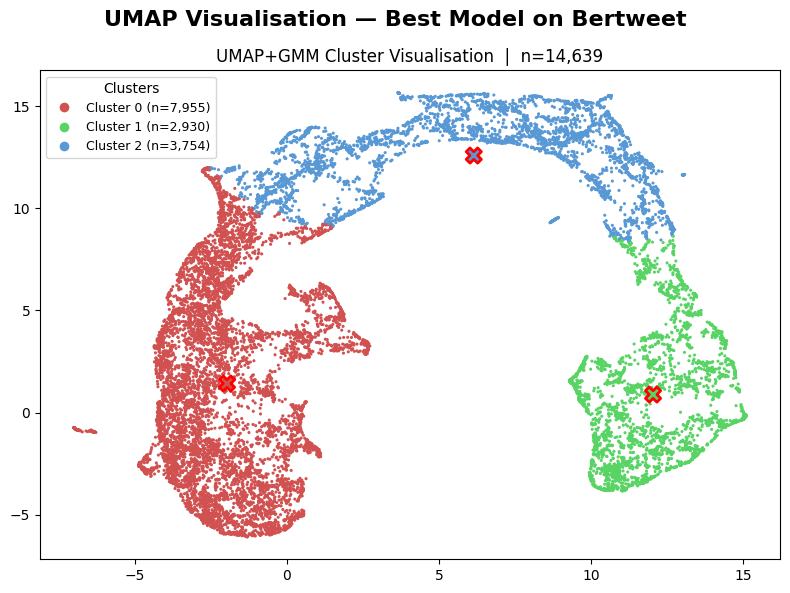

In [57]:
# ===========================
# Visualise the best saved model (Hungarian winner)
# ===========================


RANDOM_STATE = 42
palette = ["#d15151", "#58d464", "#5898d4"]  # red / green / blue


# Load saved artifacts
META_JSON = "model/bertweet_pipeline_meta.json"
PIPE_PATH = "model/bertweet_pipeline.pkl"
EMB_PATH  = "model/X_bertweet_full.npy"


with open(META_JSON, "r") as f:
   meta = json.load(f)
winner = meta["winner"]


print(f"Best model (by Hungarian): {winner['branch']}")
print("Params:", winner["params"])


best = joblib.load(PIPE_PATH)
X_sbert_full = np.load(EMB_PATH, mmap_mode="r")
labels = best.labels_


# ---------------------------
# Reduce to 2D for plotting
# ---------------------------
umap_2d = umap.UMAP(
   n_neighbors=50, min_dist=0.1, n_components=2,
   metric="euclidean", random_state=RANDOM_STATE
)
X_vis = umap_2d.fit_transform(best.X_use_)   # use the same normalized feature space used for clustering


# ---------------------------
# Plot
# ---------------------------
fig, ax = plt.subplots(figsize=(8, 6))
colors = np.array(palette)[labels]
ax.scatter(X_vis[:, 0], X_vis[:, 1], c=colors, s=5, edgecolor="none")


# Legend
unique, counts = np.unique(labels, return_counts=True)
handles = [plt.Line2D([0],[0], marker='o', color='w',
                     label=f"Cluster {k} (n={counts[i]:,})",
                     markerfacecolor=palette[k], markersize=8)
          for i,k in enumerate(unique)]
ax.legend(handles=handles, title="Clusters", loc="best", fontsize=9)


# Centroids
centroids = np.vstack([X_vis[labels==k].mean(axis=0) for k in unique])
ax.scatter(centroids[:,0], centroids[:,1], s=120, marker="X",
          c=[palette[k] for k in unique], edgecolor="red", linewidth=2.0, zorder=3)


# Titles
ax.set_title(f"{winner['branch'].upper()} Cluster Visualisation  |  n={len(labels):,}", fontsize=12)
plt.suptitle("UMAP Visualisation — Best Model on Bertweet", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()
